In [2]:
# Image segmentation with UNet on OASIS brains data

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
import os

input_dir = "keras_png_slices_data"
train_dir = "keras_png_slices_train"
test_dir = "keras_png_slices_test"
val_dir = "keras_png_slices_validate"
train_seg_dir = "keras_png_slices_seg_train"
test_seg_dir = "keras_png_slices_seg_test"
val_seg_dir = "keras_png_slices_seg_val"


train_input_image_paths = [os.path.join(input_dir, train_dir, fname) for fname in os.listdir(input_dir + "/" + train_dir)]
train_seg_image_paths = [os.path.join(input_dir, train_seg_dir, fname) for fname in os.listdir(input_dir + "/" + train_seg_dir)]
test_input_image_paths = [os.path.join(input_dir, test_dir, fname) for fname in os.listdir(input_dir + "/" + test_dir)]
test_seg_image_paths = [os.path.join(input_dir, test_seg_dir, fname) for fname in os.listdir(input_dir + "/" + test_seg_dir)]

In [4]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img
import numpy as np


class Dataset(tf.keras.utils.Sequence):
    def __init__(self, img_size, input_img_paths, seg_img_paths):
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.seg_img_paths = seg_img_paths

    def __len__(self):
        return len(self.seg_img_paths)

    def __getitem__(self, i):
        input_img_path = self.input_img_paths[i]
        seg_img_path = self.seg_img_paths[i]
        x = np.zeros((1,) + self.img_size, dtype="float32")
        img = load_img(input_img_path, target_size=self.img_size, color_mode="grayscale")
        x[0] = np.expand_dims(img, 2)
        y = np.zeros((1,) + self.img_size, dtype="uint8")
        img = load_img(seg_img_path, target_size=self.img_size, color_mode="grayscale")
        y[0] = np.expand_dims(img, 2)
        y[0] //= 85
        return x, y
    
train_ds = Dataset((256, 256, 1), train_input_image_paths, train_seg_image_paths)
test_ds = Dataset((256, 256, 1), test_input_image_paths, test_seg_image_paths)

[0 1 2 3]


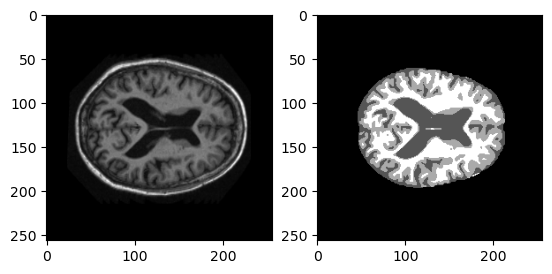

In [12]:
input_shape = None
n = 10
batch = train_ds[n]
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(batch[0][0], cmap="gray")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(batch[1][0], cmap="gray")
input_shape = batch[0][0].shape
print(np.unique(batch[1][0]))

In [6]:
def dsc(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_true = tf.keras.backend.flatten((tf.one_hot(y_true, 4, axis=-1)))
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = tf.keras.backend.flatten(tf.one_hot(y_pred, 4, axis=-1))
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2 * intersection) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred))

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, concatenate, Cropping2D, BatchNormalization
from keras.models import Model, load_model
from keras import Input
from keras.backend import int_shape
from keras.optimizers import RMSprop


def get_model(input_shape):
    """Define the UNet model given by the paper https://arxiv.org/abs/1505.04597v1"""
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    down = {64: x}
    
    for filters in [128, 256, 512, 1024]:
        # Four (4) down samples
        x = MaxPooling2D((2, 2), strides=2)(x)
        x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        down[filters] = x

    for filters in [512, 256, 128, 64]:
        # Four (4) up samples
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(x)
        x = concatenate([x, down[filters]], axis=3)        
        x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        x = BatchNormalization()(x)

    x = Conv2D(4, (1, 1), activation="softmax")(x)    
    return Model(inputs, x)

try:
    model = load_model("3", custom_objects={'dsc': dsc})
except IOError:
    model = get_model(input_shape)    
    optimizer = RMSprop(learning_rate=1e-5, momentum=0.9)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy", dsc])
    fit = model.fit(train_ds, epochs=5, validation_data=test_ds)
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_11 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 64, 64, 256)  524544     ['batch_normalization_11[0][0]'] 
 spose)                                                                                           
                                                                                                  
 concatenate_1 (Concatenate)    (None, 64, 64, 512)  0           ['conv2d_transpose_1[0][0]',     
                                                                  'batch_normalization_5[0][0]']  
                                                                                                  
 conv2d_12

In [10]:
predictions = model.predict(test_ds)

544/544 [==============================] - 548s 1s/step


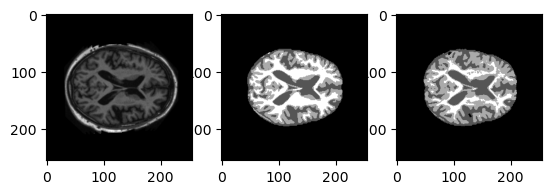

In [14]:
n = 10
batch = test_ds[n]
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(batch[0][0], cmap="gray")
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(batch[1][0], cmap="gray")
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(np.argmax(predictions[n], axis=2), cmap="gray")
input_shape = batch[0][0].shape

In [14]:
model.save("3")

INFO:tensorflow:Assets written to: 3\assets


INFO:tensorflow:Assets written to: 3\assets
